# Subsystem SCQubits Check #

The following file compares the eigenenergies of each static subsystem hamiltonian against the SCQubits implementations of the same circuits

## Filepath and Dependency Setup

In [1]:
import sys
sys.path.append('../src')
import matplotlib.pyplot as plt
import qutip as qt
import scqubits as scq
import numpy as np
import static_system 
from state_labeling import get_dressed_comp_states
import yaml
from subsystems import Subsystem
from composite_systems import CompositeSystem
from typing import Union

## Custom Implementation ##

In [2]:
# extract yaml params
yaml_path = '../config/circuit_parameters.yaml'

with open(yaml_path,'r') as stream:
    try:
        ct_params:dict[str,dict[str,float]] = yaml.safe_load(stream) 
    except yaml.YAMLError as exc:
        print(exc)

#build systems
sys = static_system.build_bare_system(ct_params, stable_nlev=6)

#extract individual circuit elements
flux_A:Subsystem = sys.subsystems['A']
flux_B:Subsystem = sys.subsystems['B']
transmon:Subsystem = sys.subsystems['C']

#extract eigenvalues
flux_A_energies = flux_A.H.eigenenergies()
flux_B_energies = flux_B.H.eigenenergies()
transmon_energies= transmon.H.eigenenergies()

## SC Qubits Implementation

In [3]:
# extract parameters
transmon_params = ct_params['C']
flux_A_params = ct_params['A']
flux_B_params = ct_params['B']

# convert to scq parameters
def custom_to_scq_params(my_params:dict[str,float],
                         circuit:str)->dict[str,float]:
    assert circuit in ['fluxonium','transmon'],'wrong circuit param'
    if circuit=='fluxonium':
        scq_params:dict[str,float] = {
            'EC': my_params['E_C']*2*np.pi, 
            'EJ': my_params['E_J']*2*np.pi,
            'EL': my_params['E_L']*2*np.pi,
            'flux': my_params['phi_ext'],
            'cutoff':100
        }
    else:
        w:float = my_params['w']
        U:float = my_params['U']
        scq_params:dict[str,float] = {
            'EJ': (w+2*U)**2/(16*U),
            'EC': 2*U,
            'ng': 0,
            'ncut':3600
        }
    return scq_params

flux_A_scq_params = custom_to_scq_params(flux_A_params, 'fluxonium')
flux_B_scq_params = custom_to_scq_params(flux_B_params, 'fluxonium')
transmon_scq_params = custom_to_scq_params(transmon_params, 'transmon')

# build circuits

flux_A_scq:scq.Fluxonium = scq.Fluxonium(**flux_A_scq_params)
flux_B_scq:scq.Fluxonium = scq.Fluxonium(**flux_B_scq_params)
transmon_scq:scq.Transmon = scq.Transmon(**transmon_scq_params)

# get eigenvalues
flux_A_scq_energies = flux_A_scq.eigenvals()
flux_B_scq_energies = flux_B_scq.eigenvals()
transmon_scq_energies = transmon_scq.eigenvals()
        

## Check that self-implementation and scq implementation agree on transmon eigenenergies

Test passes if the following cell evaluates to true

In [4]:
tare_transmon_scq_en = transmon_scq_energies - transmon_scq_energies[0]
tare_self_transmon_en = transmon_energies - transmon_energies[0]
#the following should evaluate to true
(np.abs(tare_self_transmon_en - tare_transmon_scq_en)<=1e-3).all()

True

## Check that self-implementation and scq implementation agree on fluxonium eigenenergies
Test passes if the following two cells evaluate to true

In [5]:
flux_A_scq_tared_en = flux_A_scq_energies - flux_A_scq_energies[0]
flux_A_tared_en = flux_A_energies - flux_A_energies[0]
(np.abs(flux_A_scq_tared_en - flux_A_tared_en)<=1e-3).all()

True

In [6]:
flux_B_scq_tared_en = flux_B_scq_energies - flux_B_scq_energies[0]
flux_B_tared_en = flux_B_energies - flux_B_energies[0]
(np.abs(flux_B_scq_tared_en - flux_B_tared_en)<=1e-3).all()

True

# Composite System SCQ Check

Define SCQ Composite System

In [7]:
n_transmon = transmon_scq.n_operator()
n_A = flux_A_scq.n_operator()
n_B = flux_B_scq.n_operator()
interaction_coef = ct_params['interaction']
scq_hilbertspace = scq.HilbertSpace([flux_A_scq, flux_B_scq, transmon_scq])
 #add three interaction terms
scq_hilbertspace.add_interaction(
    g=interaction_coef['g_AB']*2*np.pi,
    op1=(n_A, flux_A_scq),
    op2=(n_transmon, transmon_scq)
)
scq_hilbertspace.add_interaction(
    g=interaction_coef['g_BC']*2*np.pi,
    op1=(n_B, flux_B_scq),
    op2=(n_transmon, transmon_scq)
)
scq_hilbertspace.add_interaction(
    g=interaction_coef['g_AB']*2*np.pi,
    op1=(n_A, flux_A_scq),
    op2=(n_B, flux_B_scq)
)


Extract SCQ and Handrolled Eigenenergies

In [8]:
scq_dressed_hamiltonian = scq_hilbertspace.hamiltonian()
my_dressed_hamiltonian = sys.H 
scq_eigenenergies = scq_dressed_hamiltonian.eigenenergies()
#scq_eigenenergies -= scq_eigenenergies[0]
my_eigenenergies = my_dressed_hamiltonian.eigenenergies()
#my_eigenenergies -= my_eigenenergies[0]

print(scq_eigenenergies)
print(my_eigenenergies)

[-605.46269004 -605.45939904 -594.19677632 -594.19352866 -589.8542468
 -589.84093694 -578.59758828 -578.58571924 -575.36797737 -574.77659719
 -573.2900086  -571.23994795 -564.15253156 -563.61691491 -563.27174463
 -563.2334407  -563.16556564 -562.00651639 -560.37185109 -559.94287761
 -552.60821916 -552.52958093 -551.89558322 -550.08807902 -549.17397685
 -548.1584817  -547.66649629 -547.65165618 -541.60833448 -541.28295547
 -541.25929395 -538.82325348 -537.02266189 -536.71765664 -535.30352759
 -533.37274386 -533.25373976 -533.00615257 -532.55811673 -531.09548776
 -530.93236706 -530.19489033 -529.0375338  -525.52080299 -524.07555444
 -520.97585835 -520.39940582 -519.60695221 -518.23000959 -517.71302706
 -517.56637908 -517.54246495 -512.09303304 -510.63892172 -510.38425694
 -510.34956876 -509.13676593 -507.96637265 -506.42291661 -506.07484389
 -503.07447873 -502.52947412 -501.05108341 -500.84176087 -499.79991284
 -499.68986669 -499.516794   -499.26070974 -498.860272   -497.5905225
 -497.54

# Subsystem SCQ Plots

For Flux A

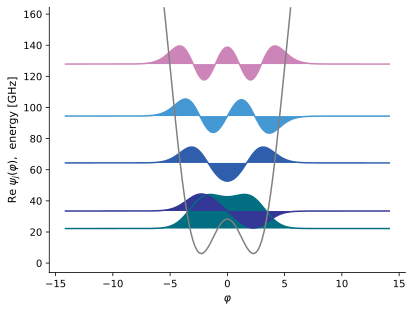

In [9]:
fig, ax = flux_A_scq.plot_wavefunction(range(5))
fig.savefig('../plots/flux_A_wavefunction_scq.png')

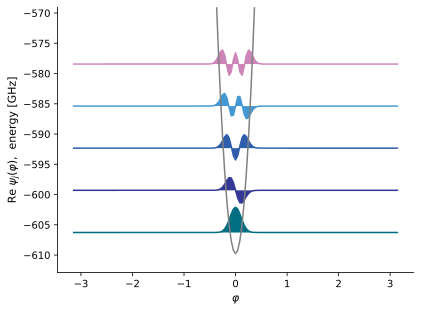

In [10]:
fig, ax = transmon_scq.plot_wavefunction(range(5))
fig.savefig('../plots/transmon_wavefunction_scq.png')

In [11]:
comp_states, comp_coords = get_dressed_comp_states(sys)

ee0_idx = comp_coords[1,1,0]
ge1_idx = comp_coords[0,1,1]
gf0_idx = comp_coords[0,2,0]
eg0_idx = comp_coords[1,0,0]
gg1_idx = comp_coords[0,0,1]
ge0_idx = comp_coords[0,1,0]

w_ee0_ge1 = (my_eigenenergies[ge1_idx] - my_eigenenergies[ee0_idx])/(2*np.pi)
w_gf0_ge1 = (my_eigenenergies[ge1_idx] - my_eigenenergies[gf0_idx])/(2*np.pi)

w_eg0_gg1 = (my_eigenenergies[gg1_idx] - my_eigenenergies[eg0_idx])/(2*np.pi)
w_ge0_gg1 = (my_eigenenergies[gg1_idx] - my_eigenenergies[ge0_idx])/(2*np.pi)

In [12]:
print(w_ee0_ge1)
print(w_gf0_ge1)
print(w_eg0_gg1)
print(w_ge0_gg1)

-0.6831645407870757
-2.1949362381490736
-0.6831645407870757
0.24820189161418463


In [13]:
diff = -0.84 - w_ee0_ge1 
print(w_gf0_ge1 + diff)
print(w_ee0_ge1 + diff)
print(diff)

-2.3517716973619978
-0.84
-0.1568354592129243


In [14]:
w_ee0_ge1_scq = (scq_eigenenergies[ge1_idx] - scq_eigenenergies[ee0_idx])/((2*np.pi))
w_gf0_ge1_scq = (scq_eigenenergies[ge1_idx] - scq_eigenenergies[gf0_idx])/((2*np.pi))
print(w_ee0_ge1_scq)
print(w_gf0_ge1_scq)

-1.791552845290013
-4.090555026020913
